<html><font size=6><B>3η εργαστηριακή άσκηση</B><BR>
    <BR><B>Link prediction - Πρόβλεψη συνδέσμων</B></BR>
    </font></html>

### Γεωργούτσος Αθανάσιος : 03117151

## Requirements

In [1]:
!pip install node2vec

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [32]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from node2vec import Node2Vec
from node2vec.edges import AverageEmbedder, HadamardEmbedder, WeightedL1Embedder, WeightedL2Embedder
import multiprocessing

<html><font size=4><B>1. Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων</B></font>
    <li><B>1(i).</B> Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>. Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.</a><BR>
        <B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.<BR></html>

- **1(i)**. Initially, I use the dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a> to build my undirected graph. 

Afterwards, I check for the existence of double edges [(a,b) twice - or - (a,b) and (b,a)]. I remove one of the doubles, if found, since they are unnecessary for my undirected graph.

Then, I plot the graph to check its structure.

No duplicate edges found.


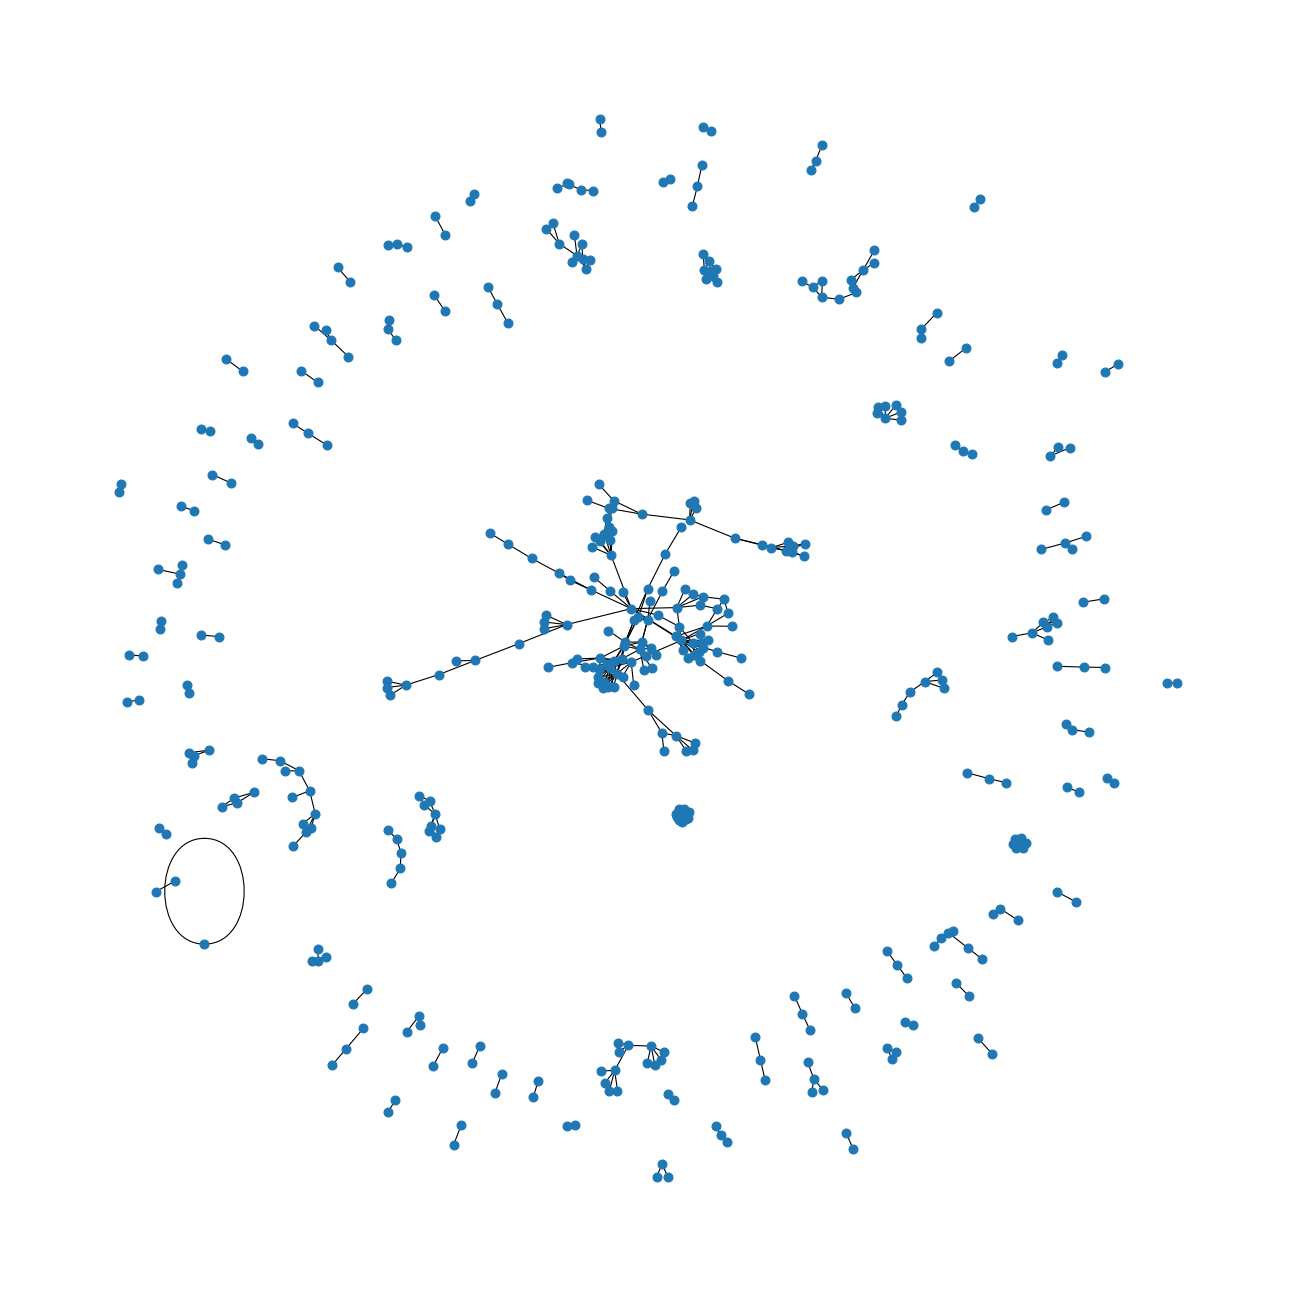

In [3]:
# building my graph
G = nx.read_edgelist("out.dbpedia-similar", nodetype=int, comments='%')

# checking edges for doubles
edges = [e for e in G.edges]

# sort edges & small number first
for (n1,n2) in edges:
    if(n1>n2):
        edges.remove((n1,n2))
        edges.append((n2,n1))
edges = sorted(edges, key=lambda tup: (tup[0],tup[1]))

doubles = []

for e1 in range(len(edges)):
    for e2 in range(e1+1, len(edges)):
        edge1 = edges[e1]
        edge2 = edges[e2]
        if((edge1[0]==edge2[0] and edge1[1]==edge2[1]) or (edge1[0]==edge2[1] and edge1[1]==edge2[0])):
            print('Found double!!')
            doubles.append(edge2)

if len(doubles)==0:
    print('No duplicate edges found.')
else:    
    # remove doubles
    for d in doubles:
        G.remove_edge(*d)
                     
# plotting graph
plt.figure(num=None, figsize=(16, 16), dpi=80)          
nx.draw(G, font_size=24, node_size=64) 

 <li><B>1(ii).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.</li><BR>

- **1(ii).** Below, I present some information for graph G: number of nodes, edges, average node degree and number of connected components. The page <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> with information on the graph validates the results below.

In [4]:
# number of nodes
node_count = len(G.nodes)
print('Nodes of G: '+str(node_count))
      
# number of edges
edge_count = len(G.edges)
print('Edges of G: '+str(edge_count))

# average_node_degree
avg_node_degree = 0
node_degrees = [d for (n,d) in G.degree()]

avg_node_degree = round(sum(node_degrees)/node_count, 5)
print('Average node degree of G: '+str(avg_node_degree))    
    
# number of connected components
con_comp_count = nx.number_connected_components(G)
print('Number of connected components of G: '+str(con_comp_count))

Nodes of G: 430
Edges of G: 565
Average node degree of G: 2.62791
Number of connected components of G: 95


<li><B>1(iii). </B>Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.</li><BR>

- **1(iii).** Finding all the unconnected pairs of the graph using the adjacency matrix.

In [5]:
# adjacency matrix
A = nx.adjacency_matrix(G, nodelist=range(1,node_count+1))

unconnected_pairs = []
for i in range(0, node_count-1):
    for j in range(i+1,node_count):
        if(A[i,j]==0):
            unconnected_pairs.append((i+1,j+1))

unconnected_pairs = sorted(unconnected_pairs, key=lambda tup: (tup[0],tup[1]))
print('Number of unconnected pairs is: '+str(len(unconnected_pairs)))            

Number of unconnected pairs is: 91671


<li><B>1(iv).</B> Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.</li><BR>

- **1(iv).** Finding removable edges, while keeping the number of connected components and the number of nodes intact.

In [6]:
removable_edges = []

# find removable edges
for e in edges:
    G.remove_edge(*e)
    
    # check connected components and nodes
    if((nx.number_connected_components(G)==con_comp_count) and (len(G.nodes)==node_count)):
        removable_edges.append(e)
    else:
        G.add_edge(*e)

# return G to its initial state
for e in removable_edges:
    G.add_edge(*e)

# sort removable edges
removable_edges = sorted(removable_edges, key=lambda tup: (tup[0],tup[1]))
    
# print number of removable edges
print('Number of removable edges is: '+str(len(removable_edges)))

Number of removable edges is: 230


<li><B>1(vα).</B> Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1(iii) και 1(iv) (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>
    <li><B>1(vβ).</B> Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1(iv). <BR>
    <li><B>1(vγ).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

- **1(vα).** Creating a dataframe, concatenating the unconnected pairs and the removable edges from the previous question. Removable edges function as positive samples and unconnected pairs as negatives (variable *link* is 1 or 0 respectively).

In [7]:
# dataframe of removable edges (they will function as positive samples)
df1 = pd.DataFrame(data=removable_edges, columns=['n1', 'n2'])
df1 = df1.assign(link=1)

# dataframe of unconnected pairs (they will function as negative samples)
df2 = pd.DataFrame(data=unconnected_pairs, columns=['n1', 'n2'])
df2 = df2.assign(link=0)

# merge in one dataframe
df = df1.append(df2, ignore_index=True)
df

,n1,n2,link
0,1,2,1
1,1,3,1
2,1,4,1
3,3,4,1
4,3,5,1
...,...,...,...
91896,426,430,0
91897,427,428,0
91898,427,429,0
91899,427,430,0


- **1(vβ).** Build *G_reduced*, by removing the removable edges from G.

In [8]:
G_reduced = G.copy()

# remove edges
for e in removable_edges:
    G_reduced.remove_edge(*e)

- **1(vγ).** Show information about G_reduced, similar to the ones presented for G.

In [9]:
# number of nodes
node_count = len(G_reduced.nodes)
print('Nodes of G_reduced: '+str(node_count))
      
# number of edges
edge_count = len(G_reduced.edges)
print('Edges of G_reduced: '+str(edge_count))

# average_node_degree
avg_node_degree = 0
node_degrees = [d for (n,d) in G_reduced.degree()]

avg_node_degree = round(sum(node_degrees)/node_count, 5)
print('Average node degree of G_reduced: '+str(avg_node_degree))    
    
# number of connected components
con_comp_count = nx.number_connected_components(G_reduced)
print('Number of connected components of G_reduced: '+str(con_comp_count))

Nodes of G_reduced: 430
Edges of G_reduced: 335
Average node degree of G_reduced: 1.55814
Number of connected components of G_reduced: 95


<html><font size=4><B>2. Εισαγωγή σε similarity-based μετρικές για Link prediction</B></font><BR><BR>
     <li> Η μετρική <B>Jaccard Coefficient (JC)</B> των κόμβων ${u}$ και ${v}$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.  <B></B>
        <li> Η μετρική <B>Preferential Αttachment (PA)</B> των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li>
        <li> Η μετρική <B>Resource Allocation (RA)</B> των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li><BR><BR>
    <li><B>2(i).</B> Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1(vβ), υπολογίστε την μετρική <B>Jaccard Coefficient (JC)</B>.  <u><a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction">Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX.<a></u> <BR><BR>
    <li><B>2(ii). </B>Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.
        (Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.)</li><BR>
    <li><B>2(iii). </B>Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα <BR>
    $Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα</li> 
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα</li><BR><BR>
        <B><U>Υπόδειξη:</U></B>
        Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
        <li>Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iv)).</li>
        <li>Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iii)).</li>
        <li>Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.</li>   
<li>Από το ερώτημα 1(iii) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.</li> <li>Από το ερώτημα 1(iv) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.</li><BR></html>

- **2(i).** Calculating Jaccard coefficient for G_reduced.

In [10]:
preds = nx.jaccard_coefficient(G_reduced)

- **2(ii).** Here, I present the edge with the highest Jaccard Coefficient from the previous step.

In [11]:
ret = (-1, -1, 0.0)

for n1, n2, p in preds:
    if p>ret[2]:
        ret = (n1, n2, p)
        
print('Edge ('+str(ret[0])+','+str(ret[1])+') has the highest Jaccard Coefficient: '+str(ret[2]))        

Edge (4,46) has the highest Jaccard Coefficient: 1.0


- **2(iii).** Precision, recall and accuracy for JC predictions (positive or negative according to a threshold). The removable edges from 1(iv) are the ones that we want to predict positive and the unconnected pairs' edges from 1(iii) are the ones that we want to predict negative.

In [12]:
# function for metrics with input threshold
def JC_metrics(threshold):
    positives = []
    negatives = []
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    preds = nx.jaccard_coefficient(G_reduced)
    for n1, n2, p in preds:
        if p>=threshold:
            positives.append((n1,n2))
        else:
            negatives.append((n1,n2))
    
    # check predictions
    for e in removable_edges:
        if e in positives:
            tp +=1
        else:
            fn +=1
            
    for e in unconnected_pairs:
        if e in positives:
            fp +=1
        else:
            tn +=1
    
    if(tn+fp!=len(unconnected_pairs)):
        print('The sum TN+FP gives '+str(tn+fp)+', while I expected '+str(len(unconnected_pairs)))
    else:
        
        recall_jc = tp / (tp+fn)
        precision_jc = tp / (tp+fp)
        accuracy_jc = (tp+tn) / (tp+fn+tn+fp)
    
        return recall_jc, precision_jc, accuracy_jc

In [13]:
# check metrics for some threshold values
thresholds = [0.1, 0.15, 0.25, 0.5, 1.0]

for t in thresholds:
    print('Checking JC threshold: '+str(t))
    
    rec, prec, acc = JC_metrics(t)
    print('JC Recall: '+str(rec))
    print('JC Precision: '+str(prec))
    print('JC Accuracy: '+str(acc))
    print()

Checking JC threshold: 0.1
JC Recall: 0.7043478260869566
JC Precision: 0.30623818525519847
JC Accuracy: 0.9952666456295362

Checking JC threshold: 0.15
JC Recall: 0.6956521739130435
JC Precision: 0.32193158953722334
JC Accuracy: 0.9955713213131522

Checking JC threshold: 0.25
JC Recall: 0.6782608695652174
JC Precision: 0.33548387096774196
JC Accuracy: 0.9958324718991088

Checking JC threshold: 0.5
JC Recall: 0.6043478260869565
JC Precision: 0.41369047619047616
JC Accuracy: 0.9968661929685205

Checking JC threshold: 1.0
JC Recall: 0.5521739130434783
JC Precision: 0.47924528301886793
JC Accuracy: 0.9973776128660189



**Observation**:

As the JC threshold increases, *recall* decreases, while *precision* and *accuracy* increase. Since there are 91671 unconnected pairs (negatives) and just 230 removable edges (positives) this is an expected behavior. Higher threshold means less positive predictions. This may lead to a slight decrease of true positives, but also to a more significant decrease of false positives, hence increasing precision. Also, there is equal increase of false negatives to the increase of true positives. Because of recall's definition, the decrease is expected. Then, because of the previous changes and the sizes of total negatives and positives, accuracy is normally increasing.  

<html><font size=4><B>3. Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών</B></font>    
        <li><B>3(i).</B> Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> για τον μειωμένο γράφο $G'$. Σημ.: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.
     <li><B>3(ii).</B> Εργαστείτε πάνω σε <B><U>αντίγραφο</U></B> του dataframe που κατασκευάσατε στο ερώτημα 1(vα) (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (<B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B>) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

- **3(i).** Method for exploring correlation between Jaccard Coefficient, Preferential Attachment and Resource Allocation.

A method to measure correlation among the similarity-based metrics above is *Pearson's coefficient*. Using the NumPy library, after having transformed the lists of values to NumPy arrays, I can simply use *np.corrcoef()* and get the matrix of Pearson correlation coefficients. Below, follows a simple implementation:

In [14]:
# calculating values
x = []
y = []
z = []

iter1 = nx.jaccard_coefficient(G_reduced)
for _,_,p in iter1:
    x.append(p)

iter2 = nx.resource_allocation_index(G_reduced)
for _,_,p in iter2:
    y.append(p)

iter3 = nx.preferential_attachment(G_reduced)
for _,_,p in iter3:
    z.append(p)
    
x = np.array(x)
y = np.array(y)
z = np.array(z)

mat1 = np.corrcoef(x,y)
print('Pearson correlation coefficient for Jaccard Coefficient and Resource Allocation is:'+str(mat1[0][1]))
print()

mat2 = np.corrcoef(x,z)
print('Pearson correlation coefficient for Jaccard Coefficient and Preferential Attachment is:'+str(mat2[0][1]))
print()

mat3 = np.corrcoef(y,z)
print('Pearson correlation coefficient for Resource Allocation and Preferential Attachment is:'+str(mat3[0][1]))
print()

Pearson correlation coefficient for Jaccard Coefficient and Resource Allocation is:0.6188972242250781

Pearson correlation coefficient for Jaccard Coefficient and Preferential Attachment is:-0.014691242921854267

Pearson correlation coefficient for Resource Allocation and Preferential Attachment is:0.0329811723966226



- **3(ii).** On a copy of the dataframe from 1(vα), I create new columns for the Jaccard Coefficient, Preferential Attachment and Resource allocation.

In [15]:
# copy dataframe
df_copy = df.copy()

# create list with edges to check
check_edges = removable_edges+unconnected_pairs
#temp = (df_copy[{'n2', 'n1'}])
#for i in range(len(temp)):
    #check_edges.append(tuple(temp.iloc[i]))
    
# calculate values of similarity-based metrics
jc_list = []
ra_list = []
pa_list = []

# jaccard coefficient
iter1 = nx.jaccard_coefficient(G_reduced, check_edges)
for u,v,p in iter1:
    jc_list.append(p)
    
# resource allocation
iter2 = nx.resource_allocation_index(G_reduced, check_edges)
for u,v,p in iter2:
    ra_list.append(p)
    
# preferential attachment    
iter3 = nx.preferential_attachment(G_reduced, check_edges)
for u,v,p in iter3:
    pa_list.append(p) 
    
# add columns
df_copy['Jacc.Coeff.'] = jc_list
df_copy['Pr.Attachment'] = pa_list
df_copy['Resource Allocation'] = ra_list

df_copy

,n1,n2,link,Jacc.Coeff.,Pr.Attachment,Resource Allocation
0,1,2,1,0.0,1,0.000000
1,1,3,1,0.0,2,0.000000
2,1,4,1,0.0,1,0.000000
3,3,4,1,0.5,2,0.142857
4,3,5,1,0.0,4,0.000000
...,...,...,...,...,...,...
91896,426,430,0,0.0,1,0.000000
91897,427,428,0,0.0,2,0.000000
91898,427,429,0,0.0,1,0.000000
91899,427,430,0,0.0,1,0.000000


<li><B>3(iiiα).</B> Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3(ii), για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.</li>
<li><B>3(iiiβ).</B> Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου. </li>
<li><B>3(iiiγ).</B>Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας. </li>  

- **3(iiiα).** Random Forest Classifier to predict links

In [16]:
# features
X = df_copy[['Jacc.Coeff.', 'Pr.Attachment', 'Resource Allocation']]

# target
y = df_copy[['link']]

# train-test sets split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# ravel targets y_train and y_test
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [17]:
# classifier
classifier = RandomForestClassifier()

# use scaler on train and test sets
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# parameters of my model
parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]} 
model = GridSearchCV(classifier, param_grid = parameters) 

In [18]:
# train the model
model.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

- **3(iiiβ).** Show the first prediction and the accuracy of the model

In [19]:
# predict
predictions = model.predict(X_test_scaled)

# print first prediction
# 1 means that I predict the future existence of the link
# 0 the opposite
print('First prediction is: '+str(predictions[0]))

acc = accuracy_score(y_test, predictions)
print('My model\'s accuracy is: '+str(acc))

First prediction is: 0
My model's accuracy is: 0.9988248607242339


- **3(iiiγ).** Probability that nodes (1,47) will connect, according to my model

In [20]:
# find features for (1,47) through df_copy
feats = df_copy.loc[df_copy['n1']==1]
feats = feats.loc[feats['n2']==47]
feats = feats[['Jacc.Coeff.', 'Pr.Attachment', 'Resource Allocation']]

# probability
predict_proba = model.predict_proba(feats)

print('Probability for link (1,47): '+str(predict_proba[0][1]))

Probability for link (1,47): 0.002175217952567804


C:\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


<html><font size=4><B>4. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks) </B></font><BR><BR>
    <li><B>4(i).</B> Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
        <BR>Για την επιλογή των παραμέτρων: 
            <li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
                <li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
                 <li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
                     <li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
                         <li>walk_length - μήκος τυχαίου περιπάτου, </li>
                             <li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li><li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
            <li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

- **4(i).** Using Node2Vec to move to lower dimensional space. Values for the parameters used were given above.

In [22]:
#generate walks
node2vec_walker = Node2Vec(G_reduced, p=1.0, q=1.0, dimensions=128, num_walks=10, walk_length=80, workers=multiprocessing.cpu_count())

#train node2vec model
n2v_model = node2vec_walker.fit(window=10, min_count=1)

Computing transition probabilities: 100%|██████████| 430/430 [00:00<00:00, 10750.39it/s]


<html><font>
    <li><B>4(ii).</B> Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.</li><BR>
    <li><B>4(iii).</B> Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

- **4(ii).** Applying Random Forest classifier to predict links.

In [23]:
# use sum as binary operator on feature vectors of the nodes of the pair I test
x = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df['n1'], df['n2'])]

In [28]:
# split to train-test sets
# I am using the result of Node2Vec for features and, again, link column as targets
X_train, X_test, y_train, y_test = train_test_split(x, df['link'], random_state = 0)

# use scaler on train and test sets
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# ravel targets y_train and y_test
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [29]:
# train classifier with train set
classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train_scaled, y_train)

# predict links
new_predictions = classifier.predict(X_test_scaled)

- **4(iii).** Accuracy for the above predictions.

In [30]:
new_acc = accuracy_score(y_test, new_predictions)
print('Accuracy with Node2Vec is: '+str(new_acc))

Accuracy with Node2Vec is: 0.9986072423398329


<html><font size=4> <B><U>Ερώτηση bonus (+10/100)</U><B>: </font>Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a> ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.</font></html>

- **Bonus Question**: Modify the code above, to use binary operators (a) Average, (b) Hadamard, (c) Weighted-L1, (d) Weighted-L2, for edge features learning.

- **AverageEmbedder**

In [33]:
average_x = [((n2v_model.wv[str(i)]+n2v_model.wv[str(j)])/2) for i,j in zip(df['n1'], df['n2'])]

# split to train-test sets
# I am using the result of Node2Vec for features and, again, link column as targets
X_train, X_test, y_train, y_test = train_test_split(average_x, df['link'], random_state = 0)

# use scaler on train and test sets
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# ravel targets y_train and y_test
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [35]:
# train classifier with train set
classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train_scaled, y_train)

# predict links
new_predictions = classifier.predict(X_test_scaled)

new_acc = accuracy_score(y_test, new_predictions)
print('Accuracy with AverageEmbedder is: '+str(new_acc))

Accuracy with AverageEmbedder is: 0.9986072423398329


- **HadamardEmbedder**

In [36]:
hadamard_x = [((n2v_model.wv[str(i)]*n2v_model.wv[str(j)])) for i,j in zip(df['n1'], df['n2'])]

# split to train-test sets
# I am using the result of Node2Vec for features and, again, link column as targets
X_train, X_test, y_train, y_test = train_test_split(hadamard_x, df['link'], random_state = 0)

# use scaler on train and test sets
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# ravel targets y_train and y_test
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [37]:
# train classifier with train set
classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train_scaled, y_train)

# predict links
new_predictions = classifier.predict(X_test_scaled)

new_acc = accuracy_score(y_test, new_predictions)
print('Accuracy with HadamardEmbedder is: '+str(new_acc))

Accuracy with HadamardEmbedder is: 0.9984766713091922


- **WeightedL1Embedder**

In [38]:
weightedL1_x = [(abs(n2v_model.wv[str(i)]-n2v_model.wv[str(j)])) for i,j in zip(df['n1'], df['n2'])]

# split to train-test sets
# I am using the result of Node2Vec for features and, again, link column as targets
X_train, X_test, y_train, y_test = train_test_split(weightedL1_x, df['link'], random_state = 0)

# use scaler on train and test sets
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# ravel targets y_train and y_test
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [39]:
# train classifier with train set
classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train_scaled, y_train)

# predict links
new_predictions = classifier.predict(X_test_scaled)

new_acc = accuracy_score(y_test, new_predictions)
print('Accuracy with WeightedL1Embedder is: '+str(new_acc))

Accuracy with WeightedL1Embedder is: 0.9975191504178273


- **WeightedL2Embedder**

In [40]:
weightedL2_x = [((abs(n2v_model.wv[str(i)]-n2v_model.wv[str(j)]))**2) for i,j in zip(df['n1'], df['n2'])]

# split to train-test sets
# I am using the result of Node2Vec for features and, again, link column as targets
X_train, X_test, y_train, y_test = train_test_split(weightedL2_x, df['link'], random_state = 0)

# use scaler on train and test sets
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# ravel targets y_train and y_test
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [41]:
# train classifier with train set
classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train_scaled, y_train)

# predict links
new_predictions = classifier.predict(X_test_scaled)

new_acc = accuracy_score(y_test, new_predictions)
print('Accuracy with WeightedL2Embedder is: '+str(new_acc))

Accuracy with WeightedL2Embedder is: 0.9975191504178273


- **Conclusions**

First, the use of Average binary operator produces the same accuracy as the use of sum as binary operator in part 4, 99.861%. This is normal, since they are the same, just on a different scale. Then, Hadamard binary operator produces slightly worse, 99.848%. The Weighted-L1 and Weighted-L2 perform the same (again, the same on different scale), but worse than the previous two, 99.752%.

This means that a representation of the feature vectors of node pairs by their half sum (Average) or their product (Hadamard) helps us more into predicting links, in contrast to the absolute value of their difference and its product with itself (Weighted-L1 and Weighted-L2 respectively).

<html><font size=4><B><U>Βιβλιογραφία:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>